# Basic usage of cucount for shear correlations

## Cutsky geometry

Let us first generate some fake data

In [1]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

from cucount.numpy import count2, count2_analytic, Particles, BinAttrs, WeightAttrs, MeshAttrs, setup_logging
import lsstypes as types
from lsstypes import Count2, Count2Correlation, ObservableTree


def generate_ellipticities(size, sigma_e=0.3, seed=42):
    """Generate random galaxy ellipticities e1, e2."""
    rng = np.random.RandomState(seed=seed)
    # Random orientation angles (0 to pi)
    phi = rng.uniform(0, np.pi, size)
    e_mag = rng.normal(0, sigma_e, size)
    e_mag = np.clip(np.abs(e_mag), 0, 0.9)
    # Compute components
    e1 = e_mag * np.cos(2 * phi)
    e2 = e_mag * np.sin(2 * phi)
    return e1, e2


def generate_catalog(size=100, limits=((0., 10.), (0., 10.)), n_individual_weights=1, n_bitwise_weights=0, seed=42):
    rng = np.random.RandomState(seed=seed)
    # Uniform in RA
    ra = rng.uniform(*limits[0], size)
    # Uniform in sin(Dec)
    sin_dec = rng.uniform(*np.sin(np.array(limits[1]) * np.pi / 180.), size)
    dec = np.arcsin(sin_dec)
    positions = [ra, dec]
    ellipticies = list(generate_ellipticities(size, seed=seed))
    weights = [rng.uniform(0.5, 1., size) for i in range(n_individual_weights)]
    return positions, ellipticies, weights

# Cutsky geometry
size = int(1e6)
data_positions, data_ellipticies, data_weights = generate_catalog(size, n_individual_weights=1, seed=42)
randoms_positions, randoms_ellipticies, randoms_weights = generate_catalog(2 * size, n_individual_weights=1, seed=84)

## Shear-shear correlation

Then compute the pair counts and Landy-Szalay estimator.

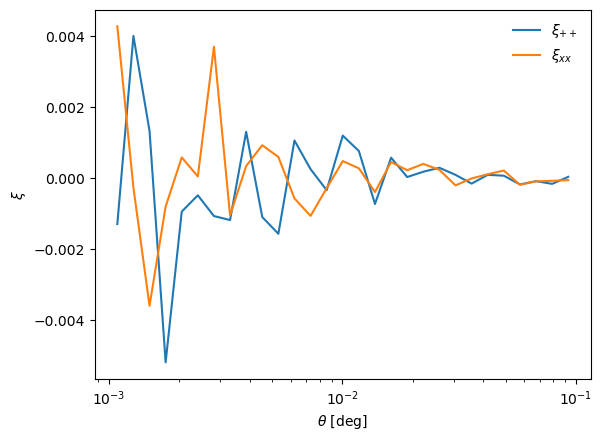

In [2]:
data = Particles(data_positions, weights=data_weights, spin_values=data_ellipticies, positions_type='rd')
randoms = Particles(randoms_positions, weights=randoms_weights, spin_values=randoms_ellipticies, positions_type='rd')

battrs = BinAttrs(theta=np.logspace(-3., -1., 30))  # in degrees
# Specify spin
wattrs = WeightAttrs(spin=(2, 2))
# With bitwise weights, one would typically do:
# wattrs = WeightAttrs(bitwise=dict(weights=data.get('bitwise_weight'), p_correction_nbits=True), (spin=(2, 2))
mattrs = None

# Helper to convert to lsstypes Count2
def to_lsstypes(battrs: BinAttrs, counts: np.ndarray, norm: np.ndarray) -> Count2:
    coords = battrs.coords()
    edges = battrs.edges()
    edges = {f'{k}_edges': v for k, v in edges.items()}
    return Count2(counts=counts, norm=norm, **coords, **edges, coords=list(coords))

# Hepler to get counts as Count2
def get_counts(*particles: Particles, autocorr=False, wattrs: WeightAttrs=None) -> Count2:
    if wattrs is None: wattrs = WeightAttrs()
    assert len(particles) == 2
    # This is the basic usage of count2
    counts = count2(*particles, battrs=battrs, wattrs=wattrs, mattrs=mattrs)
    if autocorr:
        auto_sum = wattrs(*particles).sum()
        norm = wattrs(particles[0]).sum() * wattrs(particles[1]).sum() - auto_sum
    else:
        norm = wattrs(particles[0]).sum() * wattrs(particles[1]).sum()
    return {name: to_lsstypes(battrs, counts[name], norm) for name in counts}


DD = get_counts(data, data, autocorr=False, wattrs=wattrs)
DR = get_counts(data.clone(weights=wattrs(data)), randoms, autocorr=False, wattrs=wattrs)  # clone data, with IIP weights (in case we provided bitwise weights)
RD = {name: DR.clone(value=DR.value()) for name, DR in DR.items()}
RR = get_counts(randoms, randoms, autocorr=True, wattrs=wattrs)
# Note: you can also "sum" DR, RD and RR counts over multiple random catalogs to reduce noise
# DR = types.sum(list_of_DR_counts)
# RR = types.sum(list_of_RR_counts)

correlation = [Count2Correlation(estimator='landyszalay', DD=DD[name], DR=DR[name], RD=RD[name], RR=RR[name]) for name in DD]
# Group all this in a tree
corr_types = ['++', '+x', 'xx']  # list(DD)
correlation = ObservableTree(correlation, corr_types=corr_types)
dirname = Path('_tests')
fn = dirname / 'test_lsstypes_landyszalay.h5'
dirname.mkdir(exist_ok=True)
correlation.write(fn)

correlation = types.read(fn)
ax = plt.gca()
for corr_type in ['++', 'xx']:
    corr = correlation.get(corr_type)
    ax.plot(corr.coords('theta'), corr.value(), label=rf'$\xi_{{{corr_type}}}$')
ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\theta$ [$\mathrm{deg}$]')
ax.set_ylabel(r'$\xi$')
plt.show()

## Galaxy - shear correlation

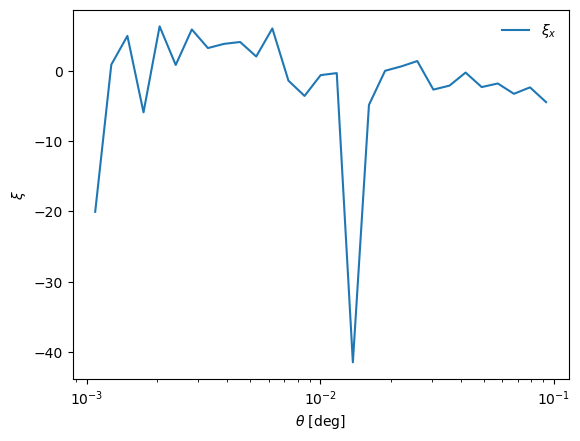

In [3]:
wattrs = WeightAttrs(spin=(0, 2))
DD = get_counts(data.clone(spin_values=None), data, autocorr=True, wattrs=wattrs)
DR = get_counts(data.clone(spin_values=None, weights=wattrs(data)), randoms, autocorr=False, wattrs=wattrs)  # clone data, with IIP weights (in case we provided bitwise weights)
RD = {name: DR.clone(value=DR.value()) for name, DR in DR.items()}
RR = get_counts(randoms.clone(spin_values=None), randoms, autocorr=True, wattrs=wattrs)
# Note: you can also "sum" DR, RD and RR counts over multiple random catalogs to reduce noise
# DR = types.sum(list_of_DR_counts)
# RR = types.sum(list_of_RR_counts)

correlation = [Count2Correlation(estimator='landyszalay', DD=DD[name], DR=DR[name], RD=RD[name], RR=RR[name]) for name in DD]
# Group all this in a tree
corr_types = ['+', 'x']  # list(DD)
correlation = ObservableTree(correlation, corr_types=corr_types)

ax = plt.gca()
for corr_type in ['x']:
    corr = correlation.get(corr_type)
    ax.plot(corr.coords('theta'), corr.value(), label=rf'$\xi_{{{corr_type}}}$')
ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\theta$ [$\mathrm{deg}$]')
ax.set_ylabel(r'$\xi$')
plt.show()